## Strong Lensing Time Delay metric

This metric is used to estimate the number of strongly lensed supernovae


## Imports

In [1]:
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import sqlite3
import numpy as np
from lsst.sims.maf.metrics.snSLMetric import SNSLMetric
import lsst.sims.maf.metrics as metrics

## DB file choice

In [2]:
dbName = 'descddf_v1.4_10yrs.db'
dbFile = '/home/philippe/LSST/DB_Files/{}'.format(dbName)
#dbName = 'kraken_2026.db'
#dbFile = dbName
opsimdb = db.OpsimDatabase(dbFile)
version = opsimdb.opsimVersion
propinfo, proptags = opsimdb.fetchPropInfo()
#print('proptags and propinfo', proptags, propinfo)
runLength = opsimdb.fetchRunLength()

fieldtype='WFD' #fieldtype: DD or WFD

sqlconstraint = opsimdb.createSQLWhere(fieldtype, proptags)

Cannot access Config table to retrieve runLength; using default 10 years


In [3]:
yearDates = list(range(0, int(round(365 * runLength)) + 365, 365))
xmin=0
xmax=0.5
plotDict = {'title': 'NSN',
                'xlabel': 'z','xMin':xmin,'xMax':xmax}
            #'nTicks':10,
           #'colorMin': xmin,'colorMax':xmax}

#plotDict['bins'] = np.arange(0.,10.,0.01)

print(yearDates)
yearDates = yearDates[:2]


[0, 365, 730, 1095, 1460, 1825, 2190, 2555, 2920, 3285, 3650]


## Define slicer

In [4]:
slicer = slicers.HealpixSlicer(nside=64)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


## Make the bundles

### Run for selected years

In [5]:
bundleList= []

sql_i = sqlconstraint

metric = SNSLMetric(coadd=True)
summaryStats = [metrics.SumMetric()]            
for i in range(len(yearDates) - 1):
    sql_y = sql_i + \
    ' AND night > %i AND night <= %i' % (
        yearDates[i], yearDates[i + 1]) #sql constraint on the year
    plotDict['title'] = 'Y{}'.format(i+1)
    print(sql_y)
    bundleList.append(metricBundles.MetricBundle(
                metric, slicer, sql_y, runName= dbName,plotDict=plotDict,summaryMetrics=summaryStats))
print(len(bundleList))

proposalId = 1 AND night > 0 AND night <= 365
1


In [6]:
outDir = '{}_SLTimeDelay'.format(dbName)
resultsDb = db.ResultsDb(outDir=outDir)
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsimdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database SummaryAllProps with constraint proposalId = 1 AND night > 0 AND night <= 365 for columns ['fieldDec', 'numExposures', 'visitTime', 'filter', 'fieldRA', 'observationStartMJD', 'night', 'visitExposureTime', 'observationId']
Found 181052 visits
Running:  ['descddf_v1_4_10yrs_db_SNSLMetric_proposalId_1_AND_night_gt_0_AND_night_lt_365_HEAL']


/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_w_2020_10/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "proposalId = 1 AND night > 0 AND night <= 365" constraint now.
monopole: 0.000140317  dipole: lon: -141.011, lat: -57.9754, amp: 3.25416e-05
Plotting complete.


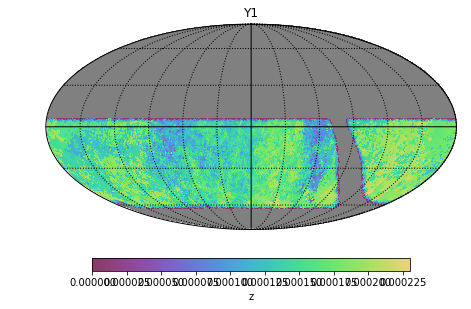

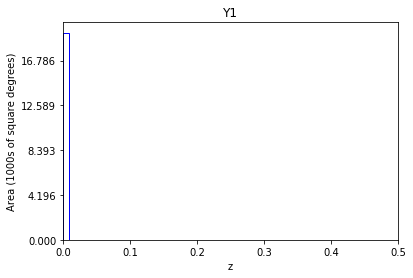

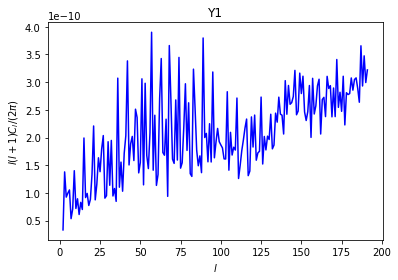

In [7]:
bgroup.plotAll(closefigs=False)

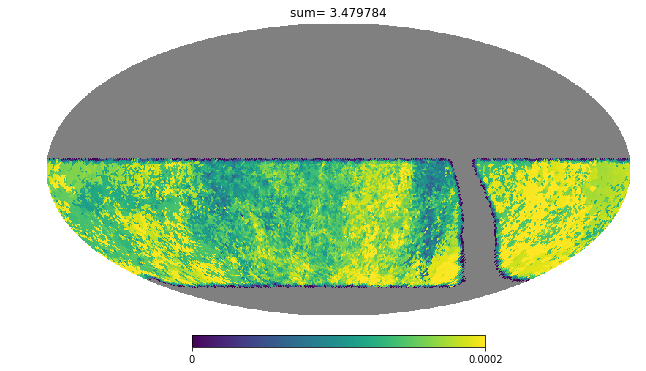

In [8]:
#Now just make the plot manually 
import healpy as hp
hp.mollview(bundleList[0].metricValues,  max=0.0002, title='sum= %f' % bundleList[0].summaryValues['Sum'])